# E-commerce Sales Prediction - Exploratory Data Analysis

This notebook contains comprehensive exploratory data analysis for the e-commerce sales prediction project. We'll analyze various aspects of the data to understand patterns and relationships that can help in predicting weekly sales.

## Setup and Data Loading

In [1]:
!pip install pyspark
!pip install findspark
!pip install seaborn

  Using cached pyspark-3.5.5-py2.py3-none-any.whl
  Using cached py4j-0.10.9.7-py2.py3-none-any.whl.metadata (1.5 kB)
Using cached py4j-0.10.9.7-py2.py3-none-any.whl (200 kB)
  Using cached findspark-2.0.1-py2.py3-none-any.whl.metadata (352 bytes)
Using cached findspark-2.0.1-py2.py3-none-any.whl (4.4 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached numpy-2.2.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached pandas-2.2.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
  Using cached matplotlib-3.10.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached contourpy-1.3.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.57.0-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (

In [2]:
!brew install git-lfs
!git lfs install
!sudo chmod -R 777 /workspace/big-data/.git/lfs/
!git lfs pull


==> Downloading https://ghcr.io/v2/homebrew/core/git-lfs/manifests/3.6.1
######################################################################### 100.0%
==> Fetching git-lfs
==> Downloading https://ghcr.io/v2/homebrew/core/git-lfs/blobs/sha256:649a26347d
######################################################################### 100.0%
==> Pouring git-lfs--3.6.1.x86_64_linux.bottle.tar.gz
==> Caveats
Update your git config to finish installation:

  # Update global git config
  $ git lfs install

  # Update system git config
  $ git lfs install --system

Bash completion has been installed to:
  /home/linuxbrew/.linuxbrew/etc/bash_completion.d
==> Summary
🍺  /home/linuxbrew/.linuxbrew/Cellar/git-lfs/3.6.1: 82 files, 13.3MB
==> Running `brew cleanup git-lfs`...
Disable this behaviour by setting HOMEBREW_NO_INSTALL_CLEANUP.
Hide these hints with HOMEBREW_NO_ENV_HINTS (see `man brew`).
==> `brew cleanup` has not been run in the last 30 days, running now...
Disable this behaviour by setting 

In [3]:
# Import required libraries
import findspark
findspark.init()

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col, when, count, mean, stddev
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Import project utilities
import sys
sys.path.append('../src')

# Set up plotting style
plt.style.use('ggplot')
sns.set_palette('husl')

In [4]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("SalesPrediction_EDA") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

# Load the dataset
df = spark.read.csv('../data/raw/BaSalam.products.csv', header=True, inferSchema=True)

# Display basic information
print("Dataset Overview:")
print(f"Number of records: {df.count():,}")
print(f"Number of features: {len(df.columns)}")
print("\nSchema:")
df.printSchema()

Picked up JAVA_TOOL_OPTIONS: -XX:+UseContainerSupport -XX:ActiveProcessorCount=1
Picked up JAVA_TOOL_OPTIONS: -XX:+UseContainerSupport -XX:ActiveProcessorCount=1
25/04/17 13:26:12 WARN Utils: Your hostname, moucode-bigdata-2hhhsf746iu resolves to a loopback address: 127.0.0.1; using 10.0.5.2 instead (on interface eth0)
25/04/17 13:26:12 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/17 13:26:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Dataset Overview:


Number of records: 2,411,358
Number of features: 43

Schema:
root
 |-- _id: integer (nullable = true)
 |-- _score: double (nullable = true)
 |-- sales_count_week: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- price: integer (nullable = true)
 |-- status_id: integer (nullable = true)
 |-- status_title: string (nullable = true)
 |-- stock: integer (nullable = true)
 |-- photo_MEDIUM: string (nullable = true)
 |-- photo_SMALL: string (nullable = true)
 |-- rating_average: double (nullable = true)
 |-- rating_count: integer (nullable = true)
 |-- rating_signals: integer (nullable = true)
 |-- primaryPrice: integer (nullable = true)
 |-- preparationDays: integer (nullable = true)
 |-- weight: integer (nullable = true)
 |-- categoryId: integer (nullable = true)
 |-- has_delivery: boolean (nullable = true)
 |-- has_variation: boolean (nullable = true)
 |-- new_categoryId: integer (nullable = true)
 |-- navigation_id: integer (nullable = true)
 |-- vendor_name: string (nul

## Helper Functions

In [5]:
"""
Utility functions for the sales prediction project.
"""

import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, count, mean, stddev
import numpy as np
import pandas as pd


def plot_missing_values(df):
    """
    Plot missing values analysis.
    
    Args:
        df: Spark DataFrame
    """
    total_count = df.count()
    missing_counts = []
    
    for column in df.columns:
        missing_count = df.filter(col(column).isNull()).count()
        missing_percentage = (missing_count / total_count) * 100
        missing_counts.append({
            'column': column,
            'missing_percentage': missing_percentage
        })
    
    missing_df = pd.DataFrame(missing_counts)
    missing_df = missing_df.sort_values('missing_percentage', ascending=True)
    
    plt.figure(figsize=(10, 6))
    plt.barh(missing_df['column'], missing_df['missing_percentage'])
    plt.xlabel('Missing Percentage')
    plt.title('Missing Values Analysis')
    plt.tight_layout()
    plt.show()

def plot_correlation_matrix(df, columns):
    """
    Plot correlation matrix for specified columns.
    
    Args:
        df: Spark DataFrame
        columns: List of column names to include in correlation matrix
    """
    correlation_data = df.select(columns).toPandas()
    correlation_matrix = correlation_data.corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.show()

def detect_outliers(df, column, threshold=3):
    """
    Detect outliers using z-score method.
    
    Args:
        df: Spark DataFrame
        column: Column name to check for outliers
        threshold: Z-score threshold for outlier detection
        
    Returns:
        DataFrame: DataFrame with outlier indicators
    """
    stats = df.select(
        mean(col(column)).alias('mean'),
        stddev(col(column)).alias('stddev')
    ).collect()[0]
    
    mean_val = stats['mean']
    stddev_val = stats['stddev']
    
    return df.withColumn(
        f'{column}_zscore',
        (col(column) - mean_val) / stddev_val
    ).withColumn(
        f'{column}_is_outlier',
        (col(f'{column}_zscore').abs() > threshold)
    )

def evaluate_regression_model(predictions, label_col="label", prediction_col="prediction"):
    """
    Evaluate regression model performance.
    
    Args:
        predictions: DataFrame with actual and predicted values
        label_col: Name of the label column
        prediction_col: Name of the prediction column
        
    Returns:
        dict: Dictionary of evaluation metrics
    """
    # Calculate MSE
    mse = predictions.select(
        ((col(prediction_col) - col(label_col)) ** 2).alias("squared_error")
    ).agg({"squared_error": "avg"}).collect()[0][0]
    
    # Calculate RMSE
    rmse = np.sqrt(mse)
    
    # Calculate R-squared
    total_variance = predictions.select(
        (col(label_col) - predictions.select(mean(label_col)).collect()[0][0]) ** 2
    ).agg({"label": "sum"}).collect()[0][0]
    
    residual_variance = predictions.select(
        (col(prediction_col) - col(label_col)) ** 2
    ).agg({prediction_col: "sum"}).collect()[0][0]
    
    r2 = 1 - (residual_variance / total_variance)
    
    # Calculate MAE
    mae = predictions.select(
        (abs(col(prediction_col) - col(label_col))).alias("abs_error")
    ).agg({"abs_error": "avg"}).collect()[0][0]
    
    return {
        "mse": mse,
        "rmse": rmse,
        "r2": r2,
        "mae": mae
    }

def plot_actual_vs_predicted(predictions, label_col="label", prediction_col="prediction"):
    """
    Plot actual vs predicted values.
    
    Args:
        predictions: DataFrame with actual and predicted values
        label_col: Name of the label column
        prediction_col: Name of the prediction column
    """
    pred_data = predictions.select(label_col, prediction_col).toPandas()
    
    plt.figure(figsize=(10, 6))
    plt.scatter(pred_data[label_col], pred_data[prediction_col], alpha=0.5)
    plt.plot([pred_data[label_col].min(), pred_data[label_col].max()],
             [pred_data[label_col].min(), pred_data[label_col].max()],
             'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')
    plt.tight_layout()
    plt.show()

def save_model_metrics(metrics, model_name, output_path):
    """
    Save model evaluation metrics to a file.
    
    Args:
        metrics: Dictionary of evaluation metrics
        model_name: Name of the model
        output_path: Path to save the metrics
    """
    with open(output_path, 'a') as f:
        f.write(f"\n{model_name} Performance Metrics:\n")
        for metric, value in metrics.items():
            f.write(f"{metric}: {value:.4f}\n")
        f.write("-" * 50 + "\n") 

## 1. Missing Data Analysis

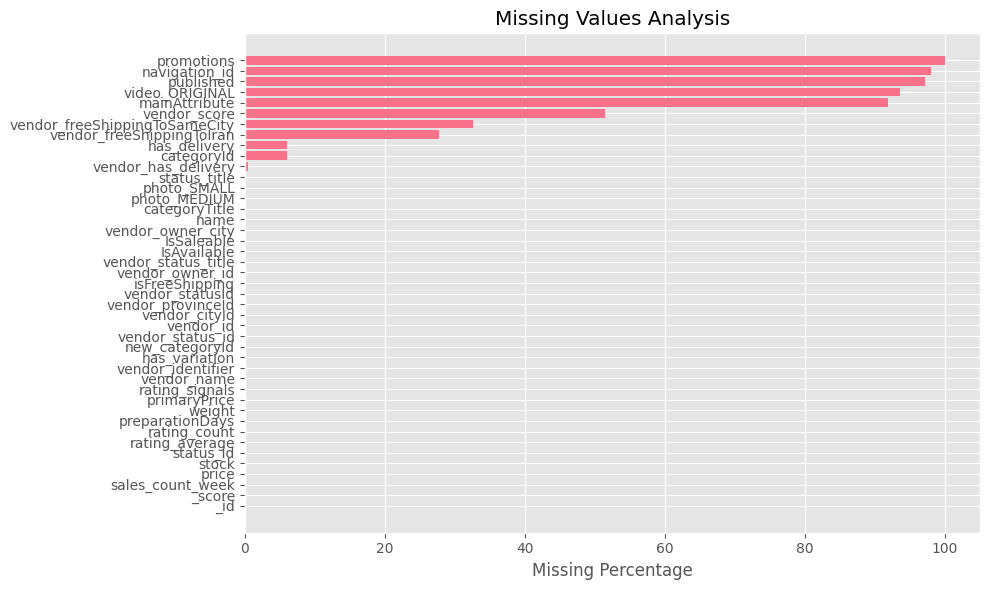

25/04/17 13:37:53 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.



Detailed Missing Value Analysis:
                           Column  Missing Count  Missing Percentage
42                     promotions        2411289           99.997139
20                  navigation_id        2363132           98.000048
40                      published        2341306           97.094915
41                 video_ORIGINAL        2254969           93.514484
38                  mainAttribute        2213550           91.796822
29                   vendor_score        1239540           51.404229
25  vendor_freeShippingToSameCity         786896           32.632898
24      vendor_freeShippingToIran         669330           27.757388
17                   has_delivery         146166            6.061564
16                     categoryId         146163            6.061439
28            vendor_has_delivery          10409            0.431665
6                    status_title           2585            0.107201
8                    photo_MEDIUM            540            0.022394


In [6]:
import pandas as pd
# Analyze missing values
plot_missing_values(df)

# Get detailed missing value statistics
missing_stats = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas()
missing_stats = missing_stats.T.reset_index()
missing_stats.columns = ['Column', 'Missing Count']
missing_stats['Missing Percentage'] = (missing_stats['Missing Count'] / df.count()) * 100
missing_stats = missing_stats.sort_values('Missing Percentage', ascending=False)

print("\nDetailed Missing Value Analysis:")
print(missing_stats[missing_stats['Missing Percentage'] > 0])

## 2. Descriptive Statistics

In [7]:
from pyspark.sql import functions as F
from pyspark.sql.types import NumericType, StringType, BooleanType, IntegerType

# Assuming `df` is your DataFrame
df_schema = df.dtypes

# Lists to hold the column names
numerical_columns = []
categorical_columns = []
binary_columns = []

# Loop through the schema and classify the columns
for column, dtype in df_schema:
    if isinstance(df.schema[column].dataType, NumericType):
        numerical_columns.append(column)
    elif isinstance(df.schema[column].dataType, StringType):
        categorical_columns.append(column)
    elif isinstance(df.schema[column].dataType, BooleanType):
        binary_columns.append(column)

# Show the results
print("Numerical Columns:", numerical_columns)
print("Categorical Columns:", categorical_columns)
print("Binary Columns:", binary_columns)

Numerical Columns: ['_id', '_score', 'sales_count_week', 'price', 'status_id', 'stock', 'rating_average', 'rating_count', 'rating_signals', 'primaryPrice', 'preparationDays', 'weight', 'categoryId', 'new_categoryId', 'navigation_id', 'vendor_statusId', 'vendor_freeShippingToIran', 'vendor_freeShippingToSameCity', 'vendor_cityId', 'vendor_provinceId', 'vendor_score', 'vendor_id', 'vendor_status_id', 'vendor_owner_id']
Categorical Columns: ['name', 'status_title', 'photo_MEDIUM', 'photo_SMALL', 'vendor_name', 'vendor_identifier', 'vendor_status_title', 'vendor_owner_city', 'mainAttribute', 'categoryTitle', 'video_ORIGINAL', 'promotions']
Binary Columns: ['has_delivery', 'has_variation', 'vendor_has_delivery', 'isFreeShipping', 'IsAvailable', 'IsSaleable', 'published']


### Changing the currency to EGP

In [41]:
from pyspark.sql.functions import col

# Define the exchange rate
exchange_rate = 0.00038  # 1 Iranian Rial = 0.00038 Egyptian Pound

# Update the 'price', 'primaryPrice', 'vendor_freeShippingToIran', and 'vendor_freeShippingToSameCity' columns
df = df.withColumn('price', col('price') * exchange_rate) \
       .withColumn('primaryPrice', col('primaryPrice') * exchange_rate) \
       .withColumn('vendor_freeShippingToIran', col('vendor_freeShippingToIran') * exchange_rate) \
       .withColumn('vendor_freeShippingToSameCity', col('vendor_freeShippingToSameCity') * exchange_rate)


In [25]:
# Count the occurrences of each unique value in 'sales_count_week'
sales_count_week_distribution = df.groupBy('sales_count_week').count().orderBy('sales_count_week')

# Show the result
sales_count_week_distribution.show()


+----------------+-------+
|sales_count_week|  count|
+----------------+-------+
|               0|2334416|
|               1|  61891|
|               2|   9536|
|               3|   2812|
|               4|   1127|
|               5|    591|
|               6|    304|
|               7|    199|
|               8|    116|
|               9|    109|
|              10|     74|
|              11|     45|
|              12|     22|
|              13|     33|
|              14|     13|
|              15|     17|
|              16|     10|
|              17|      8|
|              18|     10|
|              19|      6|
+----------------+-------+
only showing top 20 rows



In [ ]:
# Count the occurrences of each unique value in 'sales_count_week'
sales_count_week_distribution = df.groupBy('_score').count().orderBy('_score')

# Show the result
sales_count_week_distribution.show()


+---------+-------+
|   _score|  count|
+---------+-------+
|      0.0|1386766|
|83.333336| 296163|
|    125.0| 156090|
|    150.0|  92186|
|166.66667|  62850|
|178.57143|  44878|
|    187.5|  33734|
|194.44444|  25060|
|    200.0|  20596|
|204.54546|  16682|
|208.33333|  16987|
|211.53847|  13206|
|214.28572|  11830|
|216.66667|   9732|
|   218.75|   8662|
|220.58824|   8084|
|222.22223|   6848|
| 223.6842|   6015|
|    225.0|   5511|
|226.19048|   4883|
+---------+-------+
only showing top 20 rows



In [24]:
# Get the number of unique product names
unique_product_count = df.select('name').distinct().count()

print(f"Number of unique product names: {unique_product_count}")


Number of unique product names: 2286035


In [44]:
# Calculate descriptive statistics for numerical features
numeric_stats = df.select(numerical_columns).describe().toPandas()
print("Numerical Features Statistics:")
display(numeric_stats)

# Display distribution plots for numerical features
# numerical_data = df.select(numerical_columns).toPandas()

# fig, axes = plt.subplots(3, 3, figsize=(15, 15))
# axes = axes.ravel()

# for idx, col in enumerate(numerical_columns):
#     if idx < len(axes):
#         sns.histplot(data=numerical_data, x=col, ax=axes[idx])
#         axes[idx].set_title(f'Distribution of {col}')

# plt.tight_layout()
# plt.show()

Numerical Features Statistics:


,summary,_id,_score,sales_count_week,price,status_id,stock,rating_average,rating_count,rating_signals,...,navigation_id,vendor_statusId,vendor_freeShippingToIran,vendor_freeShippingToSameCity,vendor_cityId,vendor_provinceId,vendor_score,vendor_id,vendor_status_id,vendor_owner_id
0,count,2411358,2411358,2411358,2411356,2411356,2411356,2411355,2411355,2411355,...,48226,2411355,1742028,1624462,2411355,2411355,1171818,2411355,2411355,2411355
1,mean,8597589.141956525,69.34688429883539,0.043767868562030195,3520.0449898123675,2976.8719417622283,32907.0406592805,1.4855676994884555,1.8926437625318544,1.8926437625318544,...,319.3239124123917,2987.000376137068,7192.885315817486,4562.865171418412,2221.1026609520372,13.971001366451642,0.4525916140561077,505573.3472533078,2987.000376137068,6273908.150367324
2,stddev,3402083.73473064,94.1673091389762,0.3214209540235807,13065.909838908383,26.627065291595756,4933175.676261697,2.1954467852079502,15.00858522542236,15.00858522542236,...,879.9023492307176,0.019390609711578684,24096.956886329655,18431.84255541179,321.5811094740018,7.813284836195351,0.49774758298567345,263082.1987844294,0.019390609711578684,4589965.069693647
3,min,20276,0.0,0,3.8000000000000003,2976,0,0.0,0,0,...,1,2987,0.0,0.0,1722,3,0,7,2987,11
4,max,13445061,491.3793,56,379999.9962,3790,1000000000,5.0,4488,4488,...,9982,2988,379999.9962,379999.9962,2967,33,1,967729,2988,15825531


In [29]:
# Get summary statistics for all columns
df_summary = df.describe()

# Filter for categorical (string) columns
categorical_columns = [field.name for field in df.schema.fields if isinstance(field.dataType, StringType)]

# Get summary statistics only for categorical columns
df_categorical_summary = df.select(categorical_columns).describe()

# Show the result
df_categorical_summary.show()


+-------+--------------------+------------+--------------------+--------------------+--------------------+--------------------+-------------------+-----------------+-------------+-------------+--------------------+--------------------+
|summary|                name|status_title|        photo_MEDIUM|         photo_SMALL|         vendor_name|   vendor_identifier|vendor_status_title|vendor_owner_city|mainAttribute|categoryTitle|      video_ORIGINAL|          promotions|
+-------+--------------------+------------+--------------------+--------------------+--------------------+--------------------+-------------------+-----------------+-------------+-------------+--------------------+--------------------+
|  count|             2411350|     2408773|             2410818|             2410818|             2411355|             2411355|            2411355|          2411351|       197808|      2411312|              156389|                  69|
|   mean|                NULL|        NULL|             

## 3. Sales Analysis

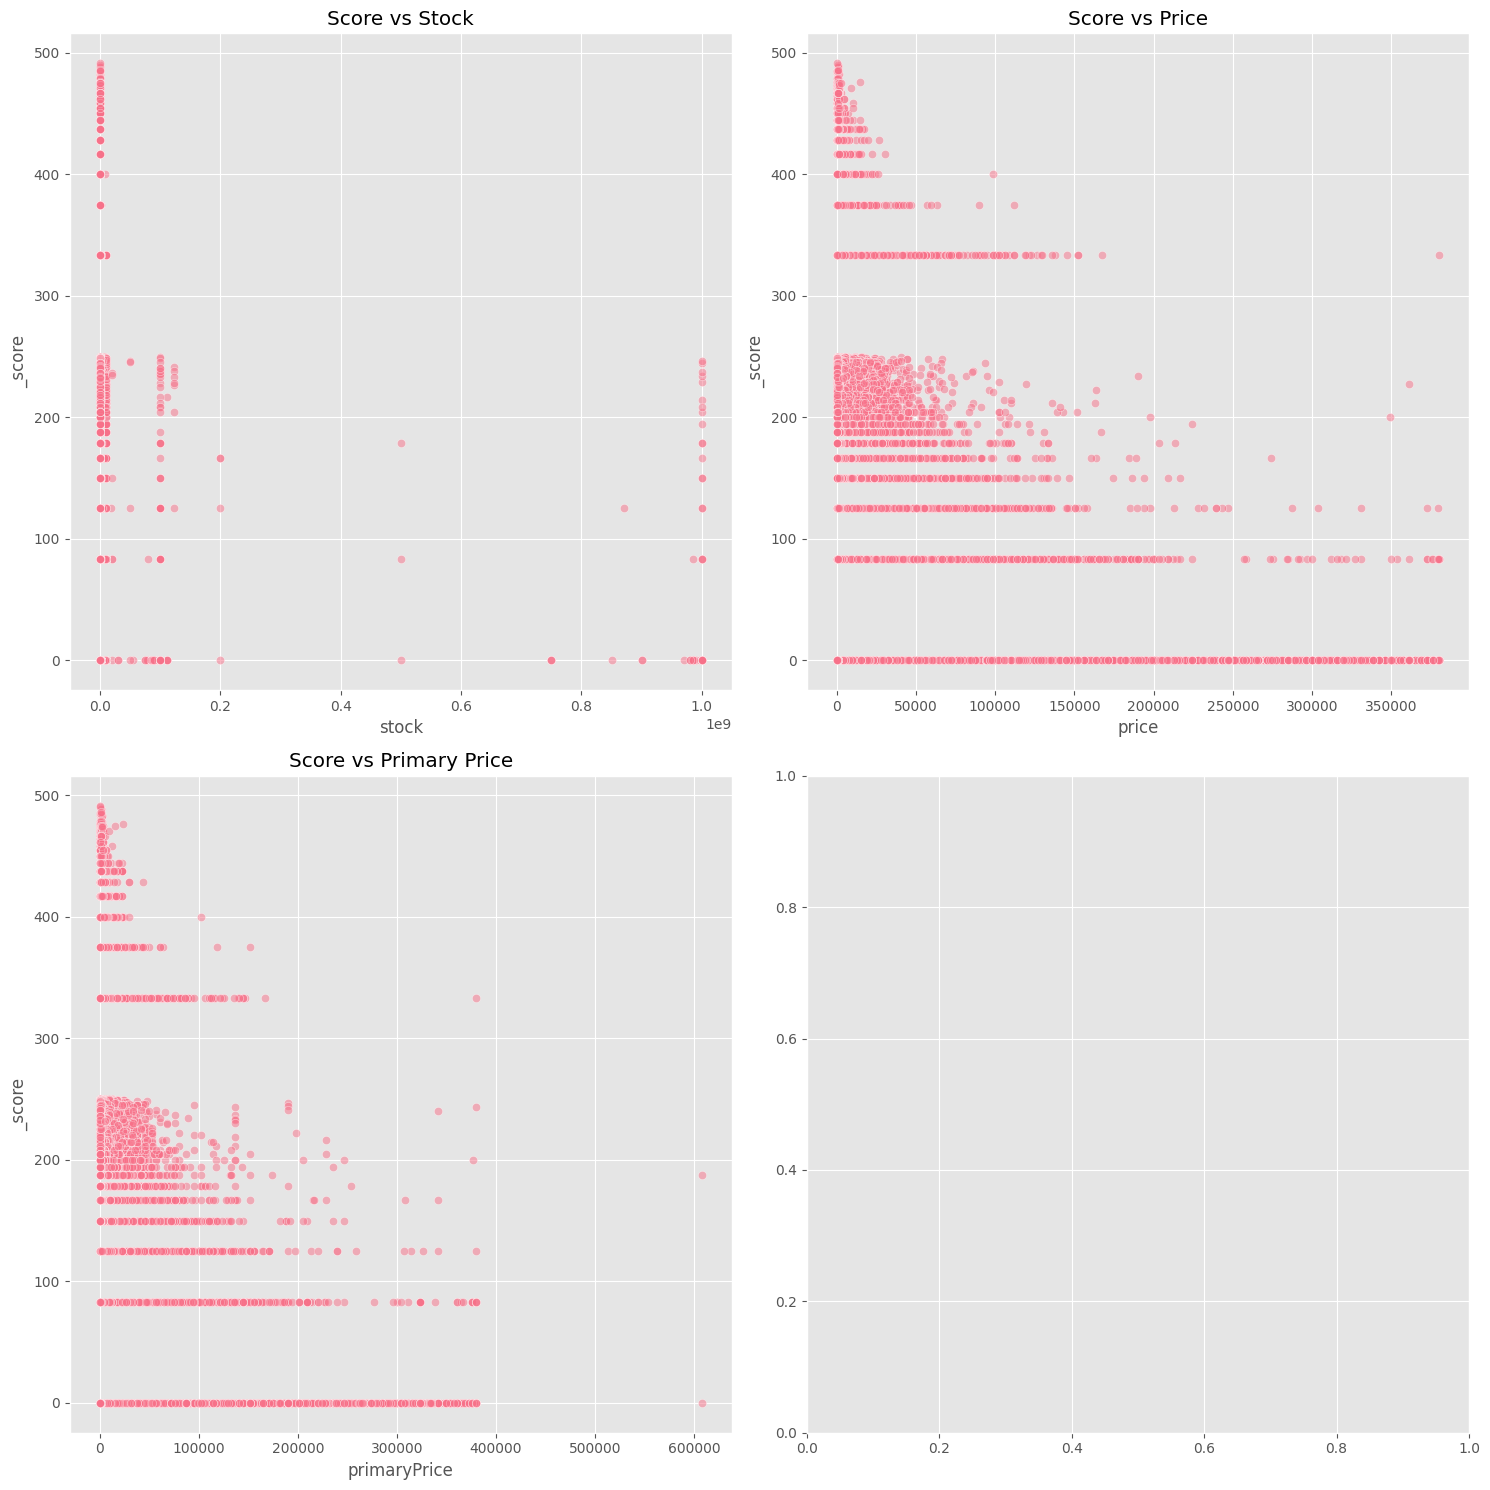

In [42]:
# Analyze relationship between sales, stock, and price
sales_analysis = df.select('_score', 'stock', 'price', 'primaryPrice').toPandas()

fig, axes = plt.subplots(2, 2, figsize=(15, 15))

# Sales vs Stock
sns.scatterplot(data=sales_analysis, x='stock', y='_score', ax=axes[0,0], alpha=0.5)
axes[0,0].set_title('Score vs Stock')

# Sales vs Price
sns.scatterplot(data=sales_analysis, x='price', y='_score', ax=axes[0,1], alpha=0.5)
axes[0,1].set_title('Score vs Price')

# Sales vs Primary Price
sns.scatterplot(data=sales_analysis, x='primaryPrice', y='_score', ax=axes[1,0], alpha=0.5)
axes[1,0].set_title('Score vs Primary Price')

plt.tight_layout()
plt.show()

## 4. Category Analysis

In [ ]:
# Get the number of unique categories
unique_categories = df.select('categoryTitle').distinct().count()

print(f"Number of unique categories: {unique_categories}")

# Get all unique category titles
unique_category_titles = df.select('categoryTitle').distinct().collect()

# Display the unique categories
for category in unique_category_titles:
    print(category['categoryTitle'])



Number of unique categories: 814


شکلات و آبنبات
زیورآلات دخترانه
فرش ماشینی
اکسسوری ورزشی
سویشرت ، هودی و ژاکت مردانه
بلوز و پیراهن مردانه
جوراب و جوراب شلواری دخترانه
ابزار بسته بندی
سایر تجهیزات اداری
سایر تجهیزات ذخیره‌سازی اطلاعات
سس
ماشین ظرفشویی
کی پد گوشی
بست و واشر
ابزار شماره دوزی
ابزار های پزشکی
تلویزیون
لوله و اتصالات
تنقلات
شوینده ظروف
دکوراتیو سفالی و سرامیکی
قلم کاری
کرم دست، صورت و بدن
ساز های کلیددار و الکترونیک
روغن خودرو
دفاع مقدس
کلوچه و نان شیرینی
ماست
ابزار مینا کاری
کفشور
قاشق، چنگال و کارد
دکوراتیو مسی
لوسیون
تبلت
سرکه
مجسمه
لوازم جانبی هدفون و هدست
شعله افکن
ظروف سرامیکی
کارت حافظه
بادام هندی
دامن دخترانه
گلیم و قالیچه
مجلات داخلی
لوازم جانبی کارت خوان و صندوق فروشگاهی
صندلی
بهداشت جنسی
سیم کلاچ و ترمز خودرو
روغن‌های خوراکی
قهوه
خمیر دندان
کش و چسب لیفت
آینه خودرو
ظروف سرو و پذیرایی
لوازم رزین و ویترای
ظروف پخت و پز مسی
خوشبو کننده و دهان شویه
مجسمه و تندیس
چرخ خیاطی
تجهیزات راحتی خودرو
اکسسوری زنانه
کلاه، شالگردن و دستکش مردانه
ریسه
ساز های زهی و آرشه ای
رومیزی و رانر
ماشین اصلاح
کانسیلر
ماسک 

Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:576)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:539)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:65)


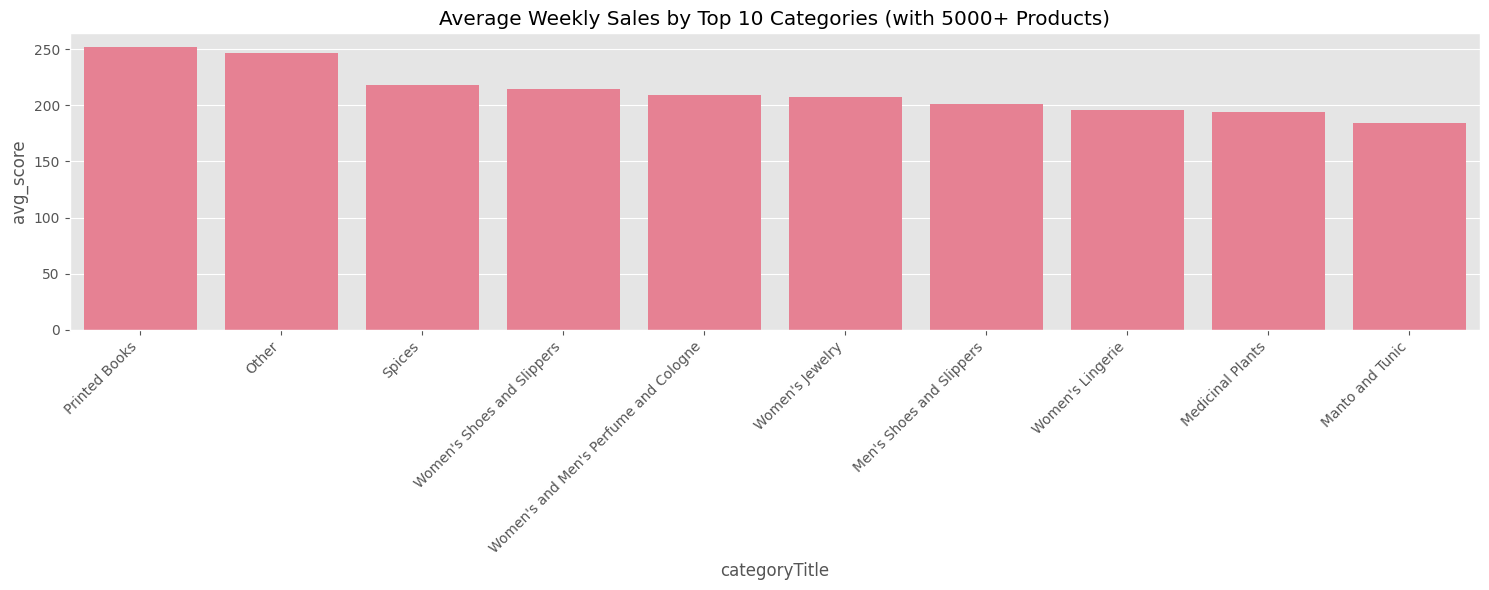


Category Statistics:


,categoryTitle,avg_score,product_count,avg_price,avg_rating
76,Printed Books,251.373766,9329,1.475267e+06,4.272205
706,Other,246.701232,10126,1.964882e+06,4.267845
346,Spices,218.256339,9270,1.243352e+06,4.264962
524,Women's Shoes and Slippers,214.143012,8863,3.896412e+06,4.099774
460,Women's and Men's Perfume and Cologne,209.250687,9054,2.566609e+06,3.820212
312,Women's Jewelry,207.369778,8967,1.649299e+06,4.211185
95,Men's Shoes and Slippers,200.975480,8926,5.909449e+06,3.990007
311,Women's Lingerie,195.632041,8813,1.372555e+06,4.109202
535,Medicinal Plants,193.886063,9018,1.552637e+06,3.562719
126,Manto and Tunic,184.599138,8687,4.483550e+06,3.777771


In [35]:
# Translation dictionary for category titles
# Updated Translation dictionary for category titles
category_translation = {
    'گام شمار': 'Pedometer',
    'کتاب چاپی': 'Printed Books',
    'طلق موتور': 'Motor Oil',
    'کفش و دمپایی زنانه': 'Women\'s Shoes and Slippers',
    'غذای ماهی و میگو': 'Fish and Shrimp Food',
    'کفش، دمپایی مردانه': 'Men\'s Shoes and Slippers',
    'بذر و تخم گیاهان': 'Seeds and Plant Seeds',
    'ذخیره سازی مبتنی بر نوار': 'Tape-based Storage',
    'عطر و ادکلن زنانه و مردانه': 'Women\'s and Men\'s Perfume and Cologne',
    'سایر': 'Other',
    'ادویه': 'Spices',
    'زیورآلات زنانه': 'Women\'s Jewelry',
    'لباس زیر زنانه': 'Women\'s Lingerie',
    'گیاهان دارویی': 'Medicinal Plants',
    'مانتو و تونیک': 'Manto and Tunic'
}


# Analyze sales by category with product count threshold
category_analysis = df.groupBy('categoryTitle').agg(
    F.avg('_score').alias('avg_score'),
    F.count('*').alias('product_count'),
    F.avg('price').alias('avg_price'),
    F.avg('rating_average').alias('avg_rating')
).toPandas()

# Apply threshold to filter out categories with less than 5000 products
category_analysis = category_analysis[category_analysis['product_count'] >= 5000]

# Translate category titles
category_analysis['categoryTitle'] = category_analysis['categoryTitle'].map(category_translation).fillna(category_analysis['categoryTitle'])

# Plot top categories by average score
plt.figure(figsize=(15, 6))
top_categories = category_analysis.nlargest(10, 'avg_score')
sns.barplot(data=top_categories, x='categoryTitle', y='avg_score')
plt.xticks(rotation=45, ha='right')
plt.title('Average Weekly Sales by Top 10 Categories (with 5000+ Products)')
plt.tight_layout()
plt.show()

# Display category statistics
print("\nCategory Statistics:")
display(category_analysis.sort_values('avg_score', ascending=False).head(10))


## 5. Shipping and Delivery Analysis

/tmp/ipykernel_2355/2595706633.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45)
/tmp/ipykernel_2355/2595706633.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45)
/tmp/ipykernel_2355/2595706633.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45)
/tmp/ipykernel_2355/2595706633.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45)


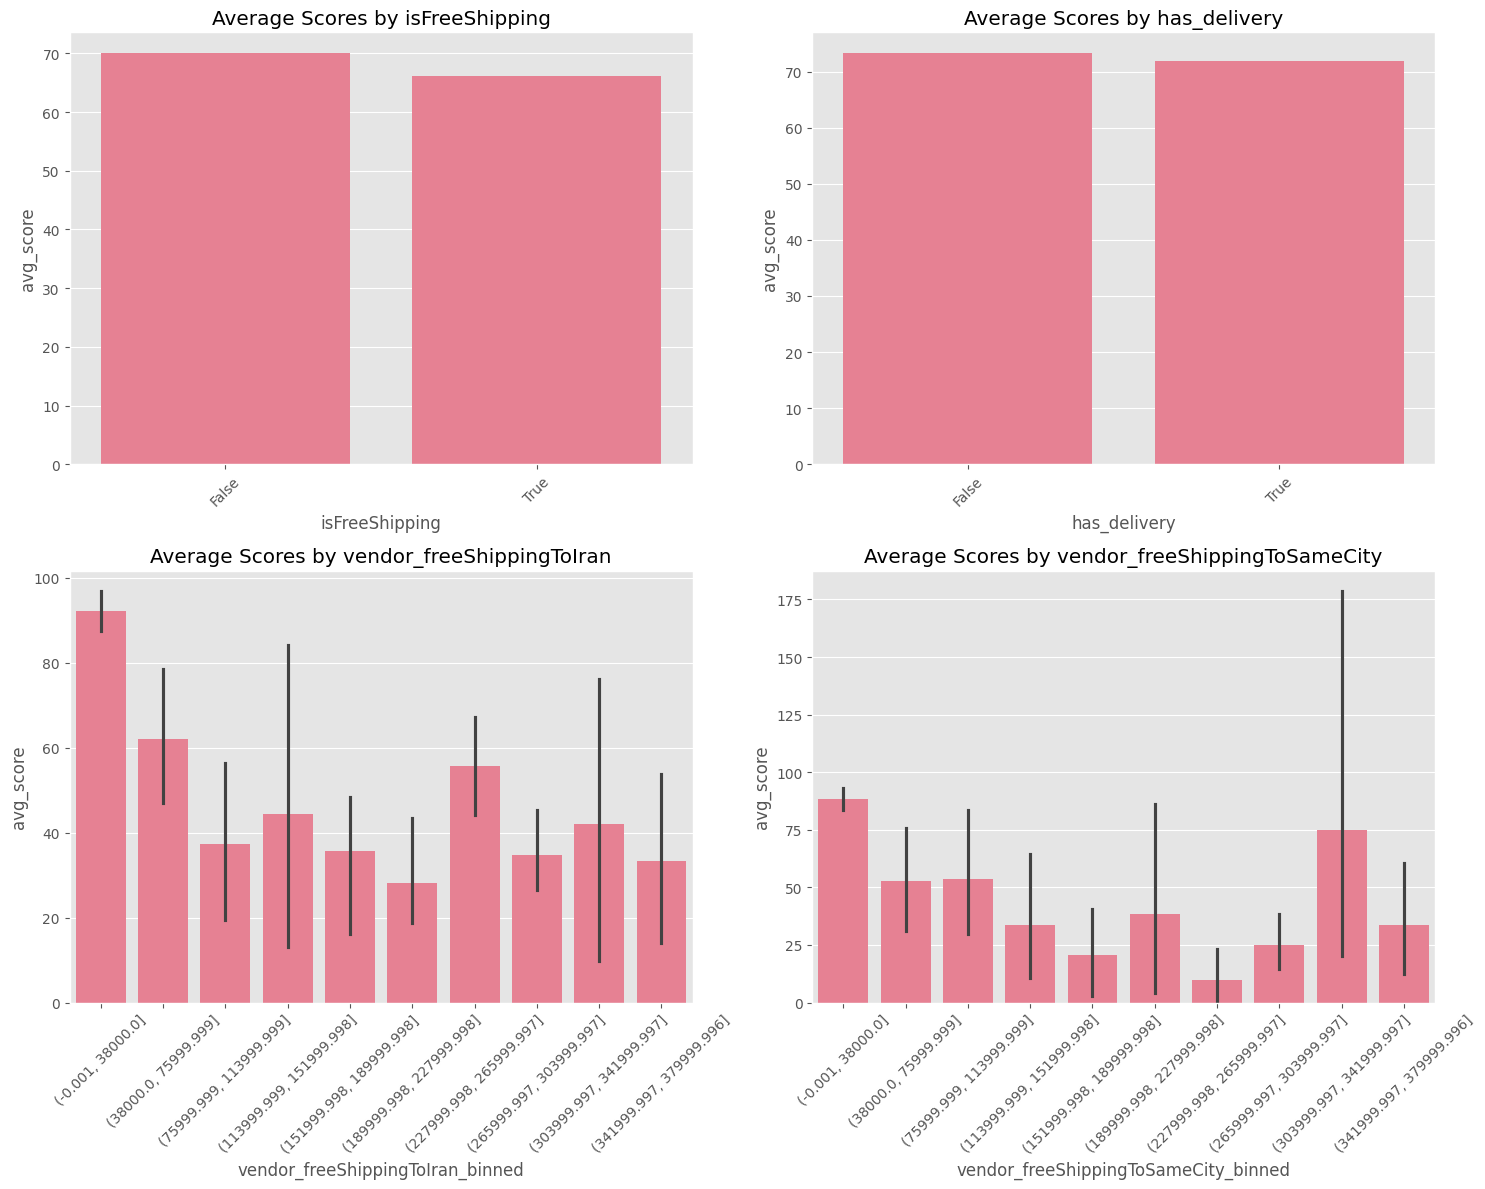

In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyspark.sql.functions as F

# Analyze impact of free shipping and delivery options
shipping_features = ['isFreeShipping', 'has_delivery',
                     'vendor_freeShippingToIran', 
                     'vendor_freeShippingToSameCity']

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for idx, feature in enumerate(shipping_features):
    # Group by feature and calculate the stats
    shipping_stats = df.groupBy(feature) \
        .agg(F.avg('_score').alias('avg_score'),
             F.count('*').alias('count')) \
        .toPandas()
    
    # Handle binning for continuous variables
    if feature in ['vendor_freeShippingToIran', 'vendor_freeShippingToSameCity']:
        # Get min and max values
        min_val = max(0, shipping_stats[feature].min())  # Ensure minimum is 0
        max_val = shipping_stats[feature].max()
        
        # Create 10 bins starting from 0
        bins = np.linspace(min_val, max_val, 11)  # 11 edges to create 10 bins
        
        # Create the binned column
        shipping_stats[feature + '_binned'] = pd.cut(shipping_stats[feature], 
                                                    bins=bins,
                                                    include_lowest=True)
        
        # Update the plot x-axis with binned feature
        x_feature = feature + '_binned'
    else:
        # For other features (like 'isFreeShipping'), just use them directly
        x_feature = feature
    
    # Handle missing values
    shipping_stats = shipping_stats.dropna(subset=[x_feature])
    
    # Plot the barplot
    sns.barplot(data=shipping_stats, x=x_feature, y='avg_score', ax=axes[idx])
    axes[idx].set_title(f'Average Scores by {feature}')
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

## 6. Vendor Analysis

6 Determine which vendors receive the highest customer satisfaction ratings. 
Are there specific vendors that consistently receive positive feedback from 
customers? 
rating_average, 
rating_count, 
vendor_name 

KeyError: 'avg_sales'

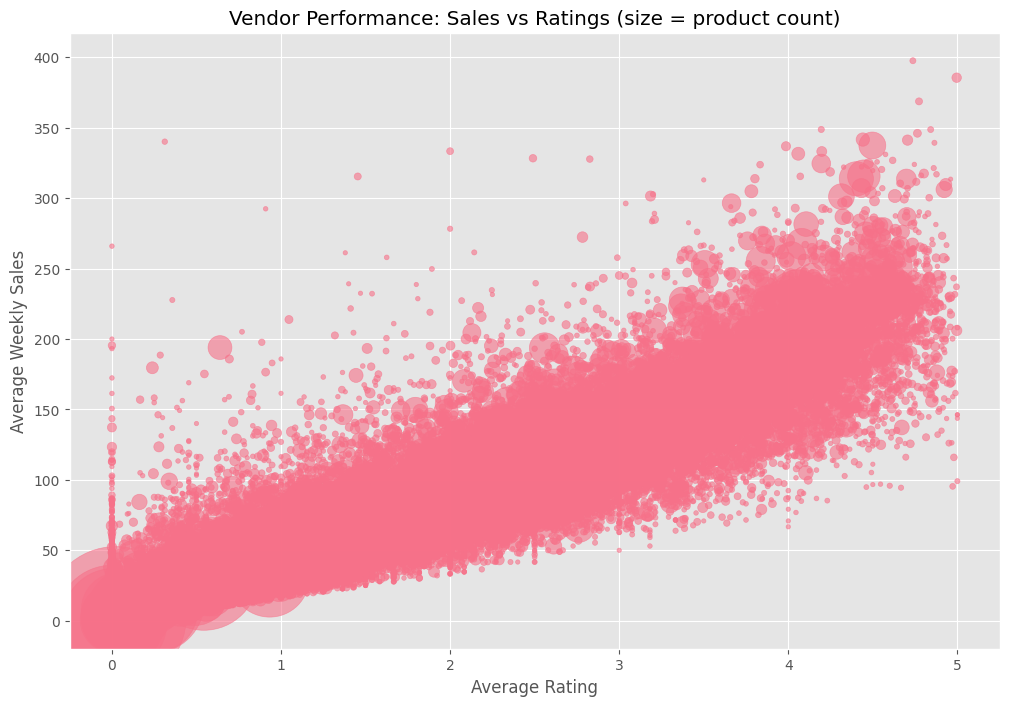

In [51]:
# Analyze vendor performance
vendor_analysis = df.groupBy('vendor_name') \
    .agg(F.avg('_score').alias('avg_score'),
         F.avg('rating_average').alias('avg_rating'),
         F.count('*').alias('product_count')) \
    .filter('product_count >= 10') \
    .toPandas()

# Plot vendor performance
plt.figure(figsize=(12, 8))
plt.scatter(vendor_analysis['avg_rating'], 
           vendor_analysis['avg_score'],
           s=vendor_analysis['product_count'],
           alpha=0.6)
plt.xlabel('Average Rating')
plt.ylabel('Average Weekly Sales')
plt.title('Vendor Performance: Sales vs Ratings (size = product count)')

# Add annotations for top performers
top_vendors = vendor_analysis.nlargest(5, 'avg_score')
for _, vendor in top_vendors.iterrows():
    plt.annotate(vendor['vendor_name'],
                 (vendor['avg_rating'], vendor['avg_sales']))

plt.tight_layout()
plt.show()

## 7. Correlation Analysis

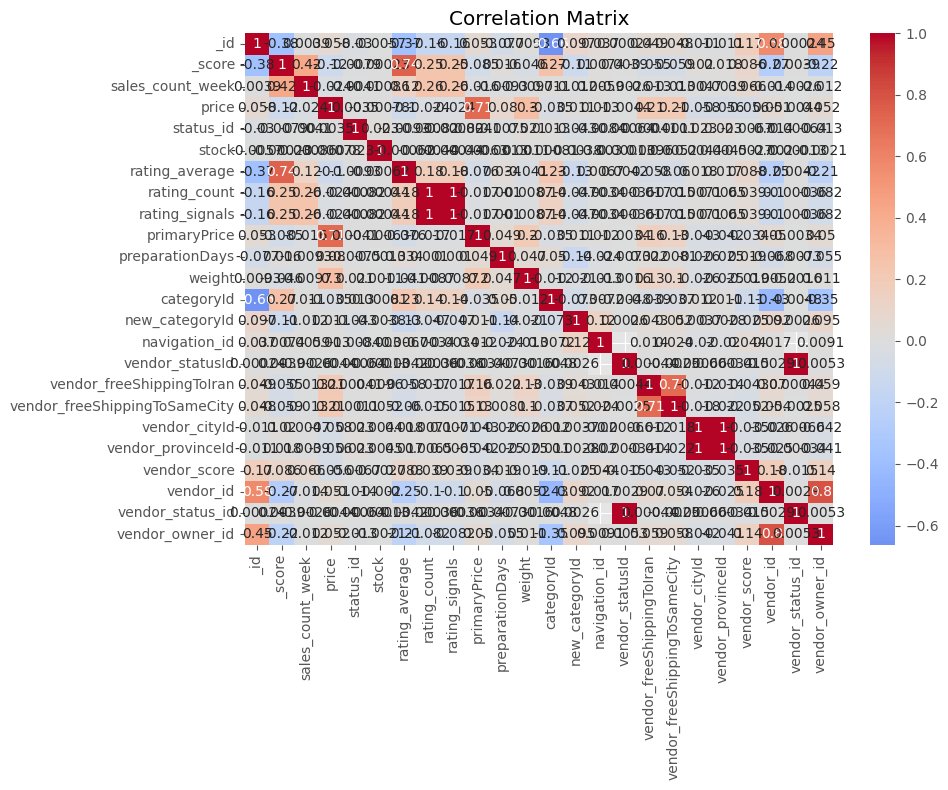


Correlations with sales_count_week:


,feature,correlation
2,sales_count_week,1.000000
1,_score,0.423761
7,rating_count,0.257689
8,rating_signals,0.257689
6,rating_average,0.123609
20,vendor_score,0.087793
3,price,-0.023692
9,primaryPrice,-0.015852
21,vendor_id,-0.014430
23,vendor_owner_id,-0.012216


In [30]:
# Calculate and plot correlation matrix
plot_correlation_matrix(df, numerical_columns)

# Calculate detailed correlations with sales
correlations = []
for feature in numerical_columns:
    correlation = df.stat.corr('sales_count_week', feature)
    correlations.append({
        'feature': feature,
        'correlation': correlation
    })

correlations_df = pd.DataFrame(correlations)
correlations_df = correlations_df.sort_values('correlation', key=abs, ascending=False)

print("\nCorrelations with sales_count_week:")
display(correlations_df)

## 8. Outlier Detection

In [ ]:
# Create box plots for numerical features
plt.figure(figsize=(15, 6))
numerical_data.boxplot(column=numerical_columns, figsize=(15, 6))
plt.xticks(rotation=45)
plt.title('Box Plots of Numerical Features')
plt.tight_layout()
plt.show()

# Detect outliers using Z-score method
outlier_stats = {}
for feature in numerical_columns:
    df_with_outliers = detect_outliers(df, feature)
    outlier_count = df_with_outliers.filter(col(f'{feature}_is_outlier')).count()
    outlier_percentage = (outlier_count / df.count()) * 100
    outlier_stats[feature] = {
        'outlier_count': outlier_count,
        'outlier_percentage': outlier_percentage
    }

print("\nOutlier Statistics (|z-score| > 3):")
outlier_df = pd.DataFrame.from_dict(outlier_stats, orient='index')
display(outlier_df)

## 9. Key Insights Summary

Based on the analysis above, here are the key insights:

1. **Missing Data**:
   - [Will be filled based on actual analysis]

2. **Sales Patterns**:
   - Relationship between sales and stock levels
   - Impact of pricing on sales
   - Effect of discounts

3. **Category Performance**:
   - Top performing categories
   - Category-wise pricing strategies

4. **Shipping Impact**:
   - Effect of free shipping on sales
   - Delivery options influence

5. **Vendor Analysis**:
   - Top performing vendors
   - Relationship between ratings and sales

6. **Correlations**:
   - Strong predictors of sales
   - Feature relationships

7. **Outliers**:
   - Distribution of extreme values
   - Impact on modeling strategy